In [1]:
from azureml.core import Workspace, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
from dateutil.relativedelta import relativedelta
import pickle
from tbats import TBATS
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm_notebook

from itertools import product
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings('ignore')

## Lasten päivystys - aikasarjamallien vertailu

In [2]:
start = pd.Timestamp('2017-01-01')
train_test_day = pd.Timestamp('2019-01-01')
end = pd.Timestamp('2019-12-31')

In [3]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='uranus27_1')
features = ['kaynti_numero', 'potilasnumero', 'henkilotunnus', 'alkuhetki', 'loppuhetki',
       'vo_toimipiste_nimi', 'kayntityyppi_selite', 'varaustyyppi_selite',
       'mista_tuli_selite', 'res_koodi', 'res_selite', 'jh_selite', 
       'jatkoh_laitos_nimi', 'jatkoh_toimipiste_nimi']
df = dataset.to_pandas_dataframe()[features]
df.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
df.drop_duplicates(subset='kaynti_numero', inplace=True)
df = df[df['varaustyyppi_selite'] != 'PÄIV PKL soitto']
df = df[(df['kayntityyppi_selite'] != 'Hoitokäynti') & (df['kayntityyppi_selite'] != 'Ohjattu muualle') & (df['kayntityyppi_selite'] !='HYKSin Oy:n potilas') & (df['kayntityyppi_selite'] != 'Sarjahoitokäynti') & (df['kayntityyppi_selite'] != 'Ensikäynti')]
df = df[(df.alkuhetki > start) & (df.alkuhetki < end)]
df_train = df[df.alkuhetki < train_test_day]
df_test = df[df.alkuhetki >= train_test_day]
pd.set_option('display.max_columns', None)
df_train = df_train.sort_values(by='alkuhetki')

In [4]:
df_train['alkuhetki'] = pd.to_datetime(df_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train['loppuhetki'] = pd.to_datetime(df_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train = df_train[df_train['alkuhetki'] <= df_train['loppuhetki']]
df_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_train['alkuhetki'], right = df_train['loppuhetki'], closed='neither')
df_train['palveluaika'] = ((df_train['loppuhetki'] - df_train['alkuhetki']).astype('timedelta64[s]') / 3600)
print('Keskiarvo:', df_train.palveluaika.mean())

Keskiarvo: 2.1664471990526284


In [5]:
df_test['alkuhetki'] = pd.to_datetime(df_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test['loppuhetki'] = pd.to_datetime(df_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test = df_test[df_test['alkuhetki'] <= df_test['loppuhetki']]
df_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_test['alkuhetki'], right = df_test['loppuhetki'], closed='neither')
df_test['palveluaika'] = ((df_test['loppuhetki'] - df_test['alkuhetki']).astype('timedelta64[s]') / 3600)

## Aikasarja päivätasolla

In [6]:
aika = start
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(730)]})
timestamp_day = [aika + timedelta(days=x) for x in range(729)]
df_train_day = pd.DataFrame(data={'time':timestamp_day})
df_train_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
df_train_day['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).contains(b) for b in df_train['alkuhetki']]).sum()
df_train_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_day['timespan']).overlaps(b) for b in df_train['aikaväli']]).sum()
df_train_day.set_index('time', inplace=True)
df_train_day.head()

,timespan,arrivals,patient_count
time,,,
2017-01-01,"[2017-01-01, 2017-01-02)",84,84
2017-01-02,"[2017-01-02, 2017-01-03)",51,56
2017-01-03,"[2017-01-03, 2017-01-04)",55,59
2017-01-04,"[2017-01-04, 2017-01-05)",51,58
2017-01-05,"[2017-01-05, 2017-01-06)",49,57


In [7]:
aika = train_test_day
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(152)]})
timestamp_day = [aika + timedelta(days=x) for x in range(151)]
df_test_day = pd.DataFrame(data={'time':timestamp_day})
df_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
df_test_day['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).contains(b) for b in df_test['alkuhetki']]).sum()
df_test_day['departments'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).contains(b) for b in df_test['loppuhetki']]).sum()
df_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_day['timespan']).overlaps(b) for b in df_test['aikaväli']]).sum()
df_test_day.set_index('time', inplace=True)

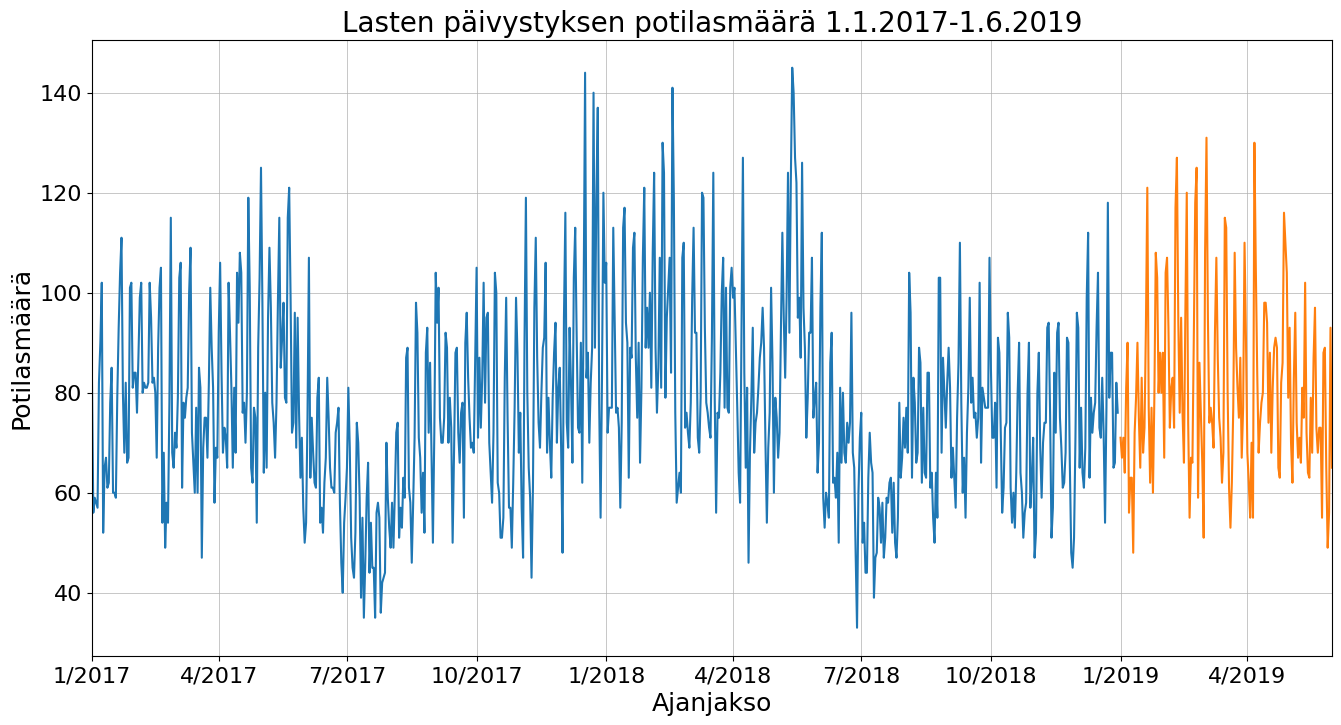

In [35]:
plt.figure(figsize=(16, 8))
plt.plot(df_train_day.index, df_train_day['patient_count'])
plt.plot(df_test_day.index, df_test_day['patient_count'])
plt.rcParams.update({'font.size': 16})
plt.title('Lasten päivystyksen potilasmäärä 1.1.2017-1.6.2019', fontsize=20)
plt.xlabel('Ajanjakso', fontsize=18)
plt.ylabel('Potilasmäärä', fontsize=18)
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'], fontsize=16)
plt.grid(linewidth=0.5)
plt.margins(x=0)
plt.show()

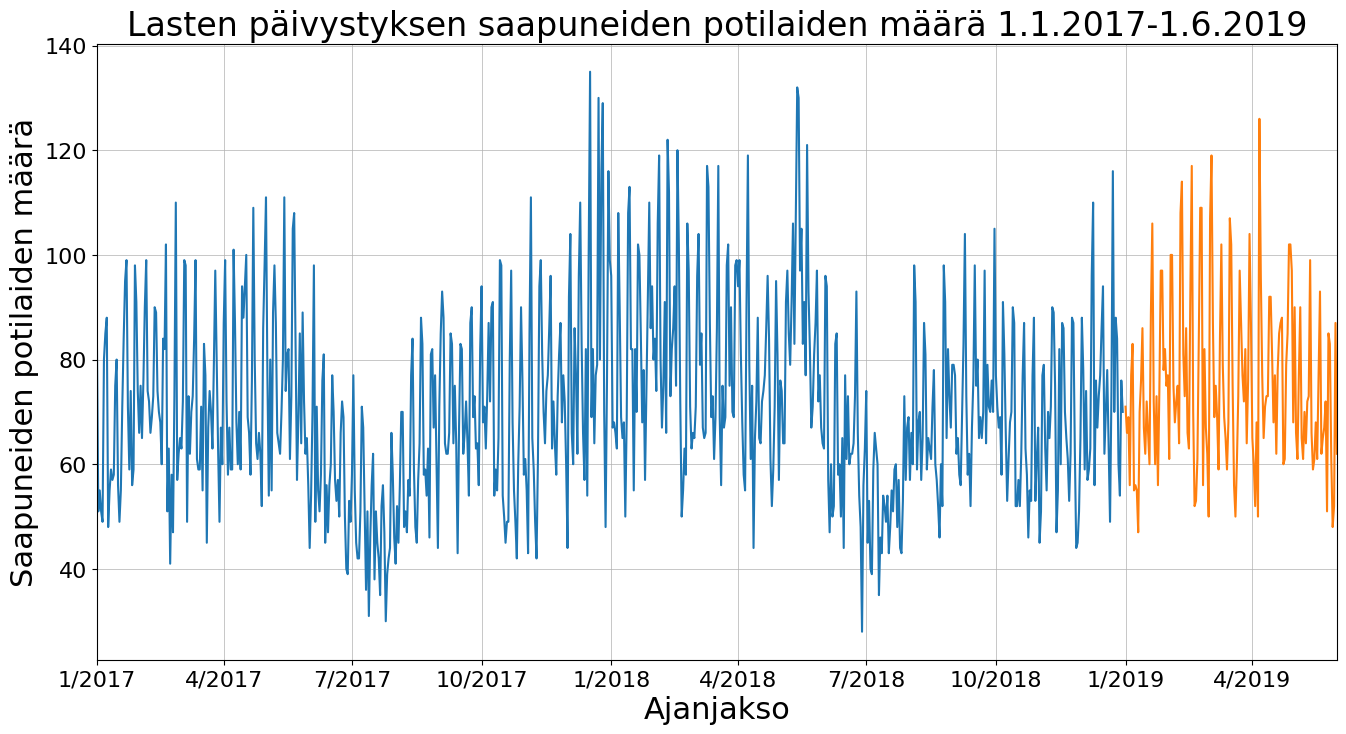

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(df_train_day.index, df_train_day['arrivals'])
plt.plot(df_test_day.index, df_test_day['arrivals'])
plt.rcParams.update({'font.size': 18})
plt.title('Lasten päivystyksen saapuneiden potilaiden määrä 1.1.2017-1.6.2019', fontsize=24)
plt.xlabel('Ajanjakso', fontsize=22)
plt.ylabel('Saapuneiden potilaiden määrä', fontsize=22)
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.grid(linewidth=0.5)
plt.margins(x=0)
plt.show()

## Kausittaisen vaihtelun analysointi

#### Saapuvat potilaat

In [10]:
aika = start
full_span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(1096)]})
full_timestamp_day = [aika + timedelta(days=x) for x in range(1095)]
df_day = pd.DataFrame(data={'time':full_timestamp_day})
df_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = full_span_day['time'][0:-1], right = full_span_day['time'][1:], closed='left')
df_day['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(df_day['timespan']).contains(b) for b in df['alkuhetki']]).sum()
df_day['departments'] = pd.DataFrame([pd.arrays.IntervalArray(df_day['timespan']).contains(b) for b in df['loppuhetki']]).sum()
df_day['weekday'] = df_day['time'].dt.weekday
df_day['month'] = df_day['time'].dt.month
week_avearr = [df_day[df_day['weekday'] == d]['arrivals'].mean() for d in range(7)]
month_avearr = [df_day[df_day['month'] == d + 1]['arrivals'].mean() for d in range(12)]
week_avedep = [df_day[df_day['weekday'] == d]['departments'].mean() for d in range(7)]
month_avedep = [df_day[df_day['month'] == d]['departments'].mean() for d in range(12)]

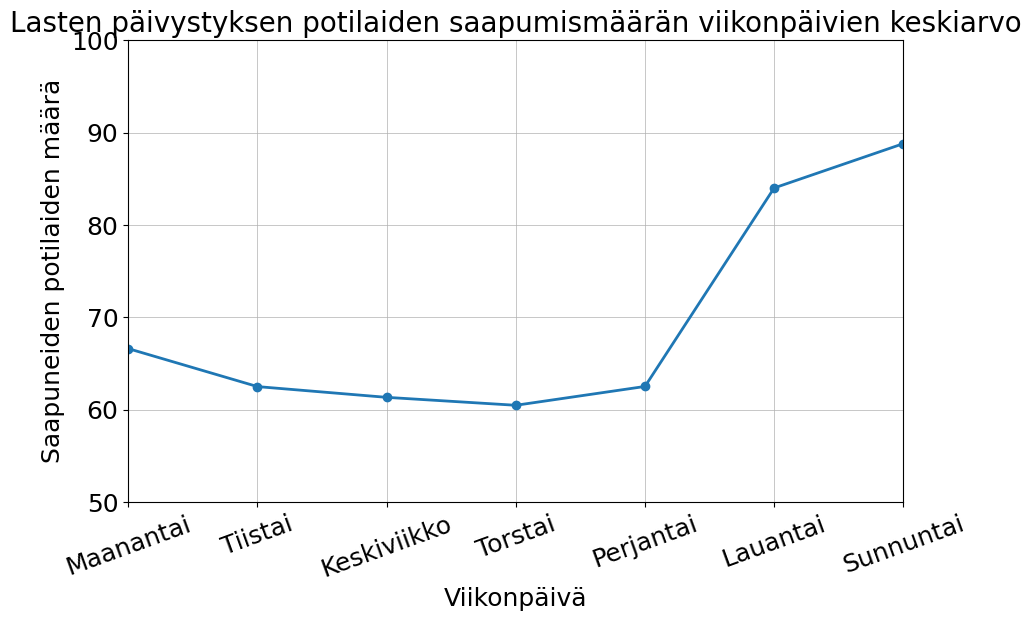

In [11]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
plt.plot(range(7), week_avearr, 'o-', linewidth=2)
plt.title('Lasten päivystyksen potilaiden saapumismäärän viikonpäivien keskiarvo', fontsize=20)
plt.xticks(range(7), labels=['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai'], rotation=20)
plt.xlabel('Viikonpäivä', fontsize=18)
plt.ylabel('Saapuneiden potilaiden määrä', fontsize=18)
plt.margins(x=0)
plt.ylim([50, 100])
plt.grid(linewidth=0.5)
plt.show()

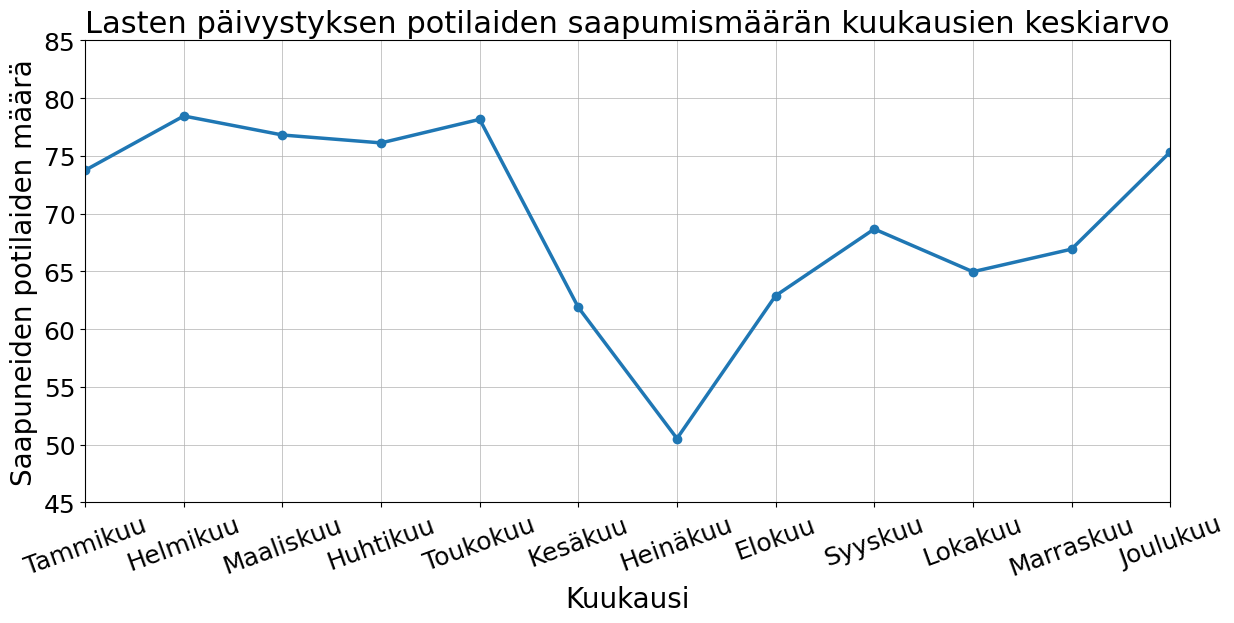

In [12]:
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 18})
plt.plot(range(12), month_avearr, 'o-', linewidth=2.5)
plt.title('Lasten päivystyksen potilaiden saapumismäärän kuukausien keskiarvo', fontsize=22)
plt.xticks(range(12), labels=['Tammikuu', 'Helmikuu', 'Maaliskuu', 'Huhtikuu', 'Toukokuu', 'Kesäkuu', 'Heinäkuu', 'Elokuu', 'Syyskuu', 'Lokakuu', 'Marraskuu', 'Joulukuu'], rotation=20)
plt.xlabel('Kuukausi', fontsize=20)
plt.ylabel('Saapuneiden potilaiden määrä', fontsize=20)
plt.margins(x=0)
plt.ylim([45, 85])
plt.grid(linewidth=0.5)
plt.show()

## Palveluajan analysointi

In [13]:
df['weekday'] = df.alkuhetki.dt.weekday
df['month'] = df.alkuhetki.dt.month
df['palveluaika'] = ((df['loppuhetki'] - df['alkuhetki']).astype('timedelta64[s]') / 3600)
tammi = df[df.month == 0].groupby(by='weekday').mean()
helmi = df[df.month == 1].groupby(by='weekday').mean()
maalis = df[df.month == 2].groupby(by='weekday').mean()
huhti = df[df.month == 3].groupby(by='weekday').mean()
touko = df[df.month == 4].groupby(by='weekday').mean()
kesa = df[df.month == 5].groupby(by='weekday').mean()
heina = df[df.month == 6].groupby(by='weekday').mean()
elo = df[df.month == 7].groupby(by='weekday').mean()
syys = df[df.month == 8].groupby(by='weekday').mean()
loka = df[df.month == 9].groupby(by='weekday').mean()
marras = df[df.month == 10].groupby(by='weekday').mean()
joulu = df[df.month == 11].groupby(by='weekday').mean()

palveluajat = [tammi.palveluaika, helmi.palveluaika, maalis.palveluaika, huhti.palveluaika, touko.palveluaika, kesa.palveluaika, heina.palveluaika, elo.palveluaika, syys.palveluaika, loka.palveluaika, marras.palveluaika, joulu.palveluaika]
df_palveluajat = pd.DataFrame(data={'ave_palveluaika':palveluajat})
print(df_palveluajat)


                                      ave_palveluaika
0       Series([], Name: palveluaika, dtype: float64)
1   weekday
0    2.456549
1    2.377245
2    2.511...
2   weekday
0    2.414329
1    2.660468
2    2.540...
3   weekday
0    2.327366
1    2.324779
2    2.368...
4   weekday
0    2.145818
1    2.211882
2    2.418...
5   weekday
0    2.305810
1    2.195455
2    2.327...
6   weekday
0    2.148420
1    1.862594
2    2.072...
7   weekday
0    2.191868
1    2.132612
2    2.074...
8   weekday
0    2.392044
1    2.275938
2    2.150...
9   weekday
0    1.985714
1    2.263644
2    2.274...
10  weekday
0    2.148205
1    2.316233
2    2.240...
11  weekday
0    2.254513
1    2.387325
2    2.200...


## Aikasarjan stationaarisuus

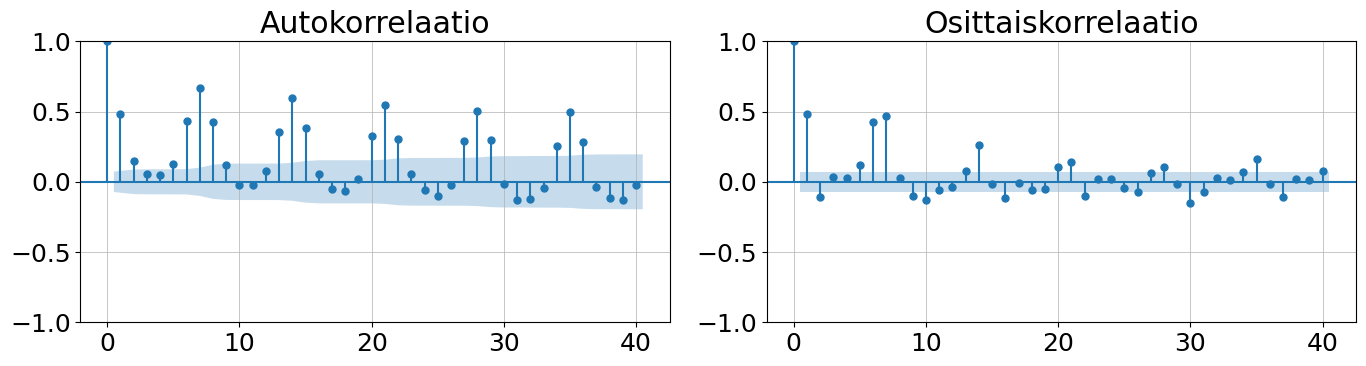

In [14]:
def correlations(y, lags):
    fig = plt.figure(figsize=(14, 4))
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, title='Autokorrelaatio')
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, title='Osittaiskorrelaatio')
    acf_ax.grid(linewidth=0.5)
    pacf_ax.grid(linewidth=0.5)
    plt.tight_layout()

correlations(df_train_day.arrivals, lags=40)

#### Ensimmäinen erotteluprosessi

Dickey-Fuller p-value: 0.0657647490772707
Dickey-Fuller p-value after 1. differencing: 1.811231046849254e-11
KPSS p-value: 0.08341552877358561
KPSS p-value after 1. differencing: 0.1


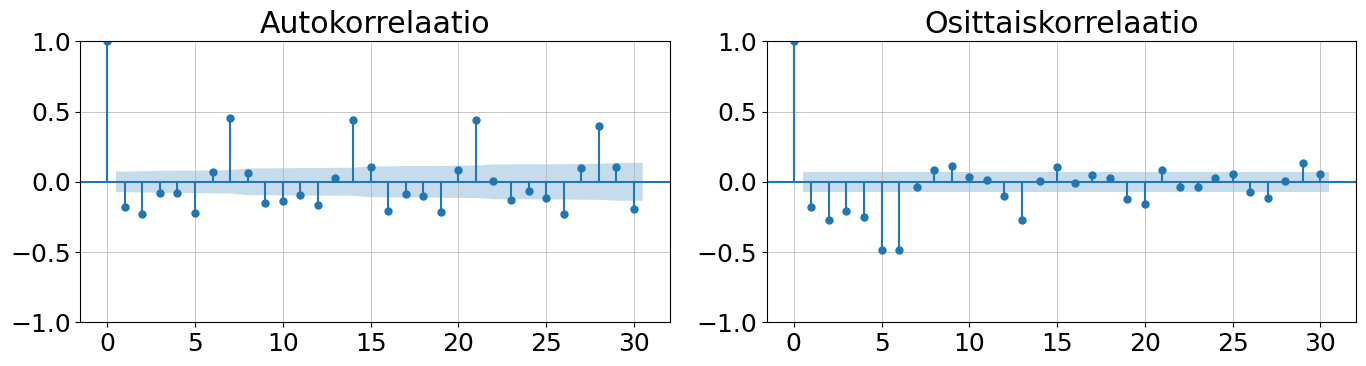

In [15]:
data_diff = df_train_day.arrivals - df_train_day.arrivals.shift(1)
print('Dickey-Fuller p-value:', adfuller(df_train_day.arrivals)[1])
print('Dickey-Fuller p-value after 1. differencing:', adfuller(data_diff[1:])[1])
print('KPSS p-value:', kpss(df_train_day.arrivals)[1])
print('KPSS p-value after 1. differencing:', kpss(data_diff[1:])[1])

correlations(data_diff[1:], lags=30)

#### Ensimmäinen kausittainen erotteluprosessi

Dickey-Fuller p-value: 0.0657647490772707
Dickey-Fuller p-value after 1.  seasonal differencing: 6.409119182832396e-11
KPSS p-value: 0.08341552877358561
KPSS p-value  after 1. seasonal differencing: 0.1


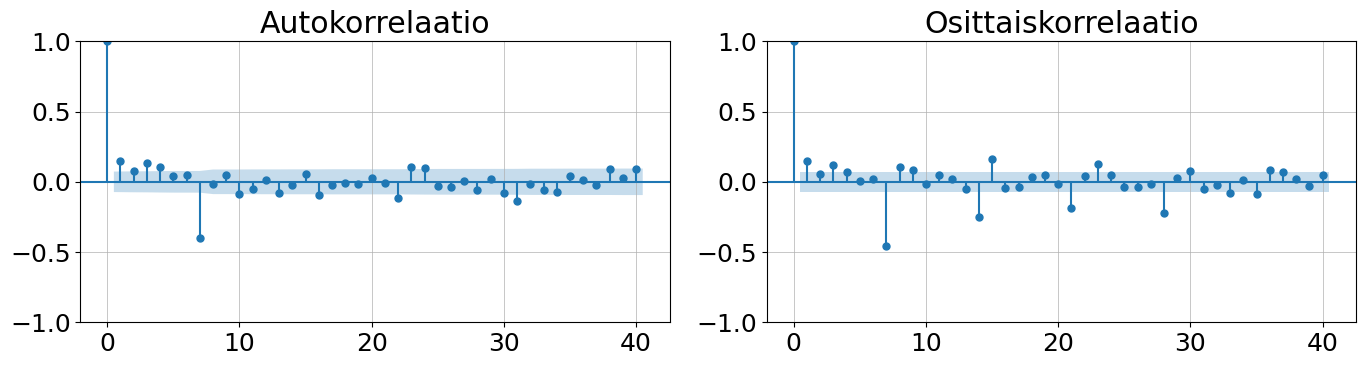

In [16]:
data_diff_seas = df_train_day.arrivals - df_train_day.arrivals.shift(7)
print('Dickey-Fuller p-value:', adfuller(df_train_day.arrivals)[1])
print('Dickey-Fuller p-value after 1.  seasonal differencing:', adfuller(data_diff_seas[7:])[1])
print('KPSS p-value:', kpss(df_train_day.arrivals)[1])
print('KPSS p-value  after 1. seasonal differencing:', kpss(data_diff_seas[7:])[1])

correlations(data_diff_seas[7:], lags=40)

### ARIMA

In [17]:
def choose_ARIMA(parameters_list, d):    
    results = []
    best_aic = float('inf')
    
    for par in tqdm_notebook(parameters_list):
        model = ARIMA(df_train_day.arrivals, order=(par[0], d, par[1])).fit() 
        aic_score = model.aic
        
        if aic_score < best_aic:
            best_model = model
            best_aic = aic_score
            best_ps = par
        results.append([par, model.aic])
        
    table = pd.DataFrame(results)
    table.columns = ['parameters', 'aic']
    table = table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return table

ps = range(1, 6)
d = 1
qs = range(5, 7)

parameters_list = list(product(ps, qs))
#results = choose_ARIMA(parameters_list, d)
#p, q = results.parameters[0]
#arima_model = ARIMA(df_train_day.arrivals, order=(p, d, q)).fit() 

arima_model = pickle.load(open('ARIMA_ER_2017-2019_final.pkl', 'rb'))
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:               arrivals   No. Observations:                  729
Model:                 ARIMA(5, 1, 6)   Log Likelihood               -2814.588
Date:                Mon, 10 Apr 2023   AIC                           5653.176
Time:                        09:03:29   BIC                           5708.260
Sample:                    01-01-2017   HQIC                          5674.431
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1354      0.604     -0.224      0.823      -1.319       1.048
ar.L2         -0.6704      0.488     -1.373      0.170      -1.627       0.286
ar.L3         -0.5676      0.867     -0.655      0.5

### SARIMA

In [18]:
def choose_SARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float('inf')
    
    for par in tqdm_notebook(parameters_list):
        model = sm.tsa.statespace.SARIMAX(df_train_day.arrivals, order=(par[0], d, par[1]), seasonal_order=(par[2], D, par[3], s)).fit()
            
        aic_score = model.aic
        if aic_score < best_aic:
            best_model = model
            best_aic = aic_score
            best_param = par
        results.append([par, model.aic])
        
    table = pd.DataFrame(results)
    table.columns = ['parameters', 'aic']
    table = table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return table

ps = range(1, 6)
d = 1
qs = range(5, 7)
Ps = range(0, 2)
D = 1
Qs = range(0, 5)
s = 7

parameters_list = list(product(ps, qs, Ps, Qs))
#result_table = choose_SARIMA(parameters_list, d, D, s)
#p, q, P, Q = result_table.parameters[0]
#sarima_model = sm.tsa.statespace.SARIMAX(df_train_day.arrivals, order=(p, d, q),
#                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

sarima_model = pickle.load(open('SARIMA_ER_2017-2019_final.pkl', 'rb'))
print(sarima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            arrivals   No. Observations:                  729
Model:             SARIMAX(2, 1, 5)x(1, 1, [1], 7)   Log Likelihood               -2766.191
Date:                             Mon, 10 Apr 2023   AIC                           5552.382
Time:                                     09:03:30   BIC                           5598.189
Sample:                                 01-01-2017   HQIC                          5570.065
                                      - 12-30-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0776      0.039    -27.654      0.000      -1.154      -1.001
ar.L2         -0.9512      

In [19]:
#pickle.dump(arima_model, open('ARIMA_ER_2017-2019_final.pkl', 'wb'))
#pickle.dump(sarima_model, open('SARIMA_ER_2017-2019_final.pkl', 'wb'))

### TBATS

In [20]:
#tbats = TBATS(seasonal_periods=[7, 365])
#tbats = tbats.fit(df_train_day.arrivals)
tbats = pickle.load(open('tbats_ER_2017-2019_final.pkl', 'rb'))
print(tbats.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 365.]
Seasonal harmonics [3 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.203228
Seasonal Parameters (Gamma): [-1.51524878e-08  8.16182611e-09 -9.13342523e-09 -4.35503976e-08]
AR coefficients []
MA coefficients []
Seed vector [58.18182165 13.64284202  5.0230468   1.39514791 -3.72740041 -5.32279315
 -1.98853697  6.61508342  6.23103292]

AIC 8340.891318


## Ennusteet

In [22]:
new_index = pd.date_range("2019-01-01", "2019-06-01")
additive = pd.DataFrame(np.nan, index=new_index[:-1], columns=df_train_day.columns)
additive.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
additive['ennuste_ARIMA'] = arima_model.predict(start=730, end=881, dynamic=True)
additive['ennuste_SARIMA'] = sarima_model.predict(start=730, end=881, dynamic=True)
ts_model = pickle.load(open('tbats_ER_2017-2019_final.pkl', 'rb'))
additive['ennuste_TBATS'] =  ts_model.forecast(steps=151)
df_train_day = pd.concat([df_train_day, additive])

In [23]:
import matplotlib
matplotlib.rc_file_defaults()

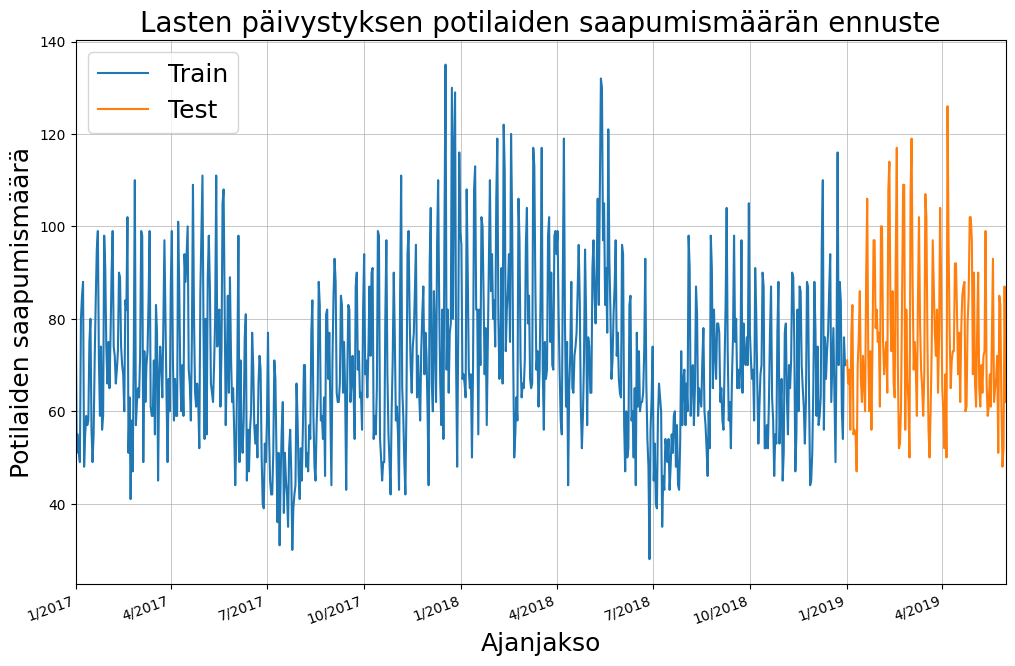

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_train_day.arrivals, ls='-', label='Train')
ax.plot(df_test_day.arrivals, ls='-', label='Test')
plt.rcParams.update({'font.size': 18})
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=20)
ax.set_xlabel('Ajanjakso', fontsize=18)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'], rotation=20)
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

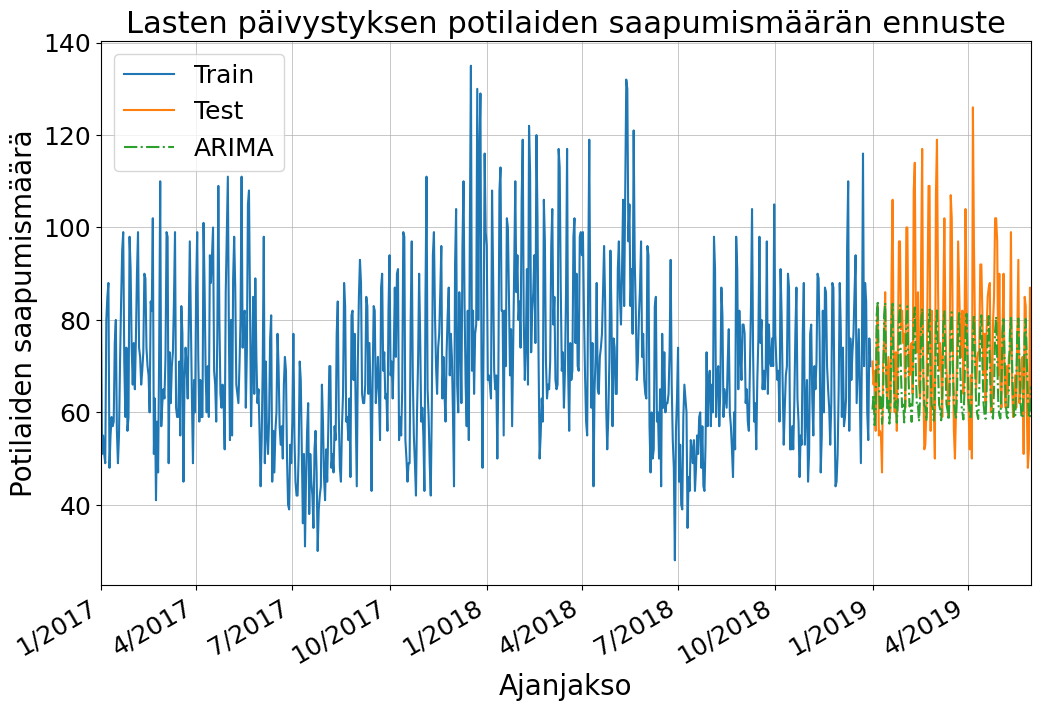

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_train_day.arrivals, ls='-', label='Train')
ax.plot(df_test_day.arrivals, ls='-', label='Test')
ax.plot(additive.ennuste_ARIMA, ls='-.', label='ARIMA')
plt.rcParams.update({'font.size': 18})
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=22)
ax.set_xlabel('Ajanjakso', fontsize=20)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=20)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

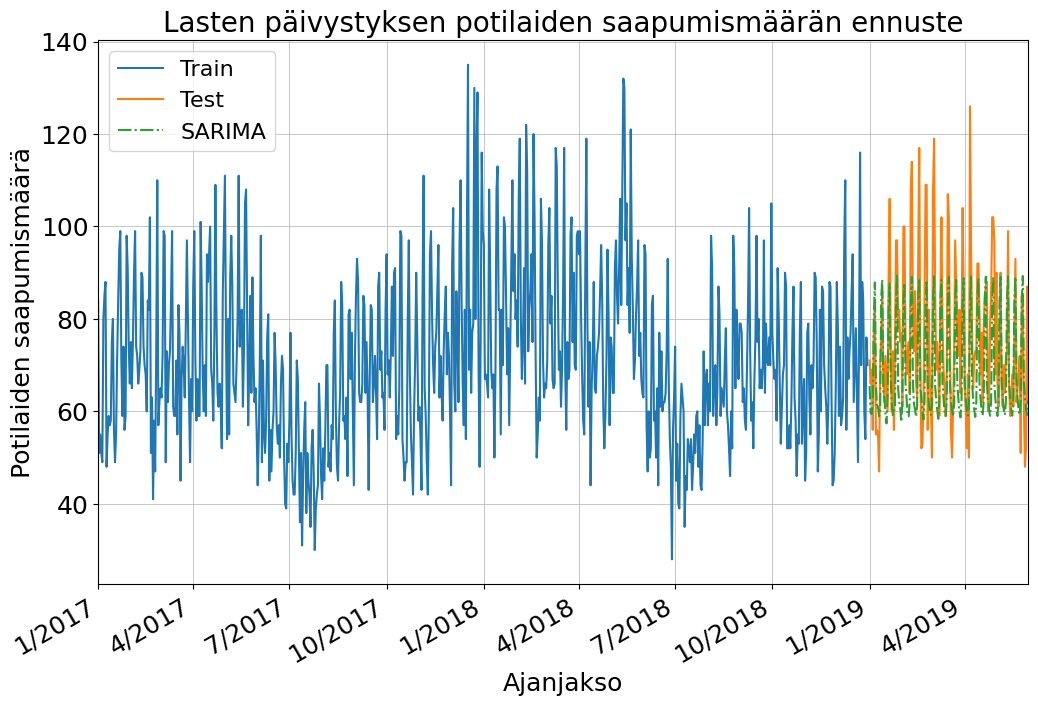

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_train_day.arrivals, ls='-', label='Train')
ax.plot(df_test_day.arrivals, ls='-', label='Test')
ax.plot(additive.ennuste_SARIMA, ls='-.', label='SARIMA')
plt.rcParams.update({'font.size': 16})
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=20)
ax.set_xlabel('Ajanjakso', fontsize=18)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

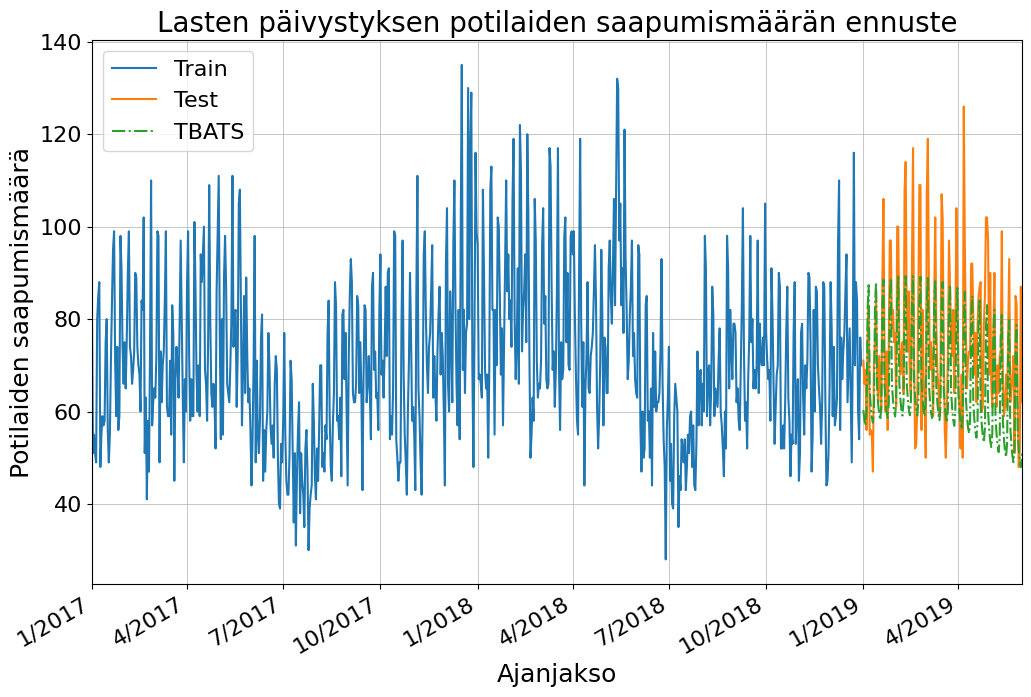

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_train_day.arrivals, ls='-', label='Train')
ax.plot(df_test_day.arrivals, ls='-', label='Test')
ax.plot(additive.ennuste_TBATS, ls='-.', label='TBATS')
plt.rcParams.update({'font.size': 16})
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=20)
ax.set_xlabel('Ajanjakso', fontsize=18)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

## Vuosiennuste

In [28]:
aika = train_test_day
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(365)]})
timestamp_day = [aika + timedelta(days=x) for x in range(364)]
year_test_day = pd.DataFrame(data={'time':timestamp_day})
year_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
year_test_day['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_day['timespan']).contains(b) for b in df_test['alkuhetki']]).sum()
year_test_day['departments'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_day['timespan']).contains(b) for b in df_test['loppuhetki']]).sum()
year_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_day['timespan']).overlaps(b) for b in df_test['aikaväli']]).sum()
year_test_day.set_index('time', inplace=True)
year_test_day.head()

,timespan,arrivals,departments,patient_count
time,,,,
2019-01-01,"[2019-01-01, 2019-01-02)",71,70,71
2019-01-02,"[2019-01-02, 2019-01-03)",66,65,67
2019-01-03,"[2019-01-03, 2019-01-04)",69,61,71
2019-01-04,"[2019-01-04, 2019-01-05)",56,62,64
2019-01-05,"[2019-01-05, 2019-01-06)",77,74,81


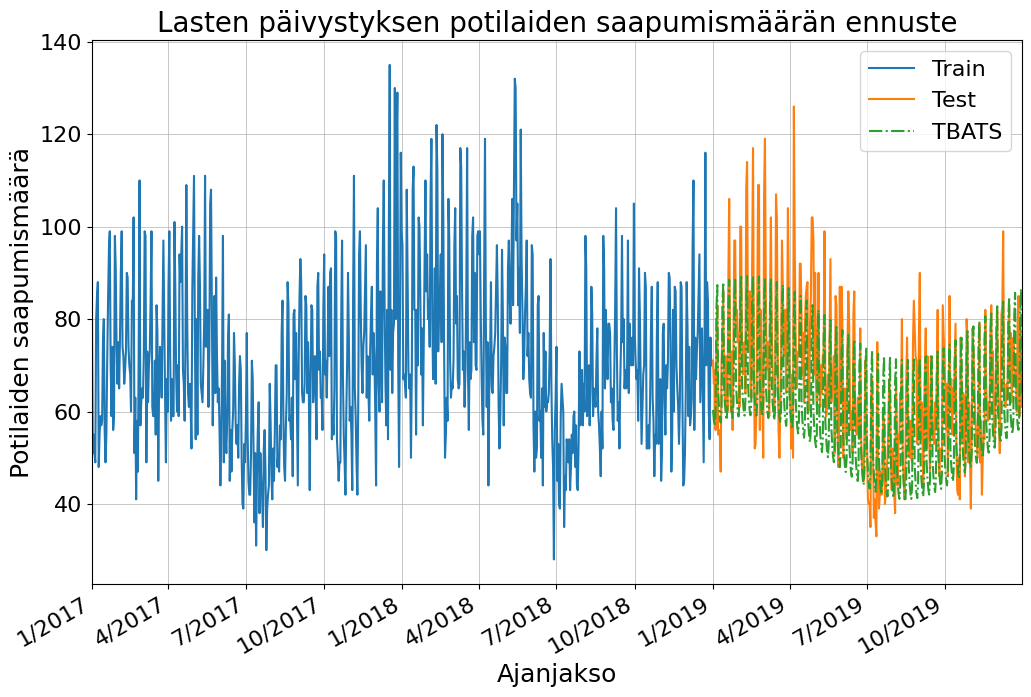

In [29]:
new_index = pd.date_range("2019-01-01", "2019-12-31")
year_pred = pd.DataFrame(np.nan, index=new_index[:-1], columns=df_train_day.columns)
year_pred.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
year_pred['TBATS'] = ts_model.forecast(steps=364)

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams.update({'font.size': 16})
ax.plot(df_train_day.arrivals, ls='-', label='Train')
ax.plot(year_test_day.arrivals, ls='-', label='Test')
ax.plot(year_pred.TBATS, ls='-.', label='TBATS')
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=20)
ax.set_xlabel('Ajanjakso', fontsize=18)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01'), pd.Timestamp('2019-07-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-12-31')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019', '7/2019', '10/2019', '1/2020'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

## 2,5 vuoden datalla koulutettu malli 

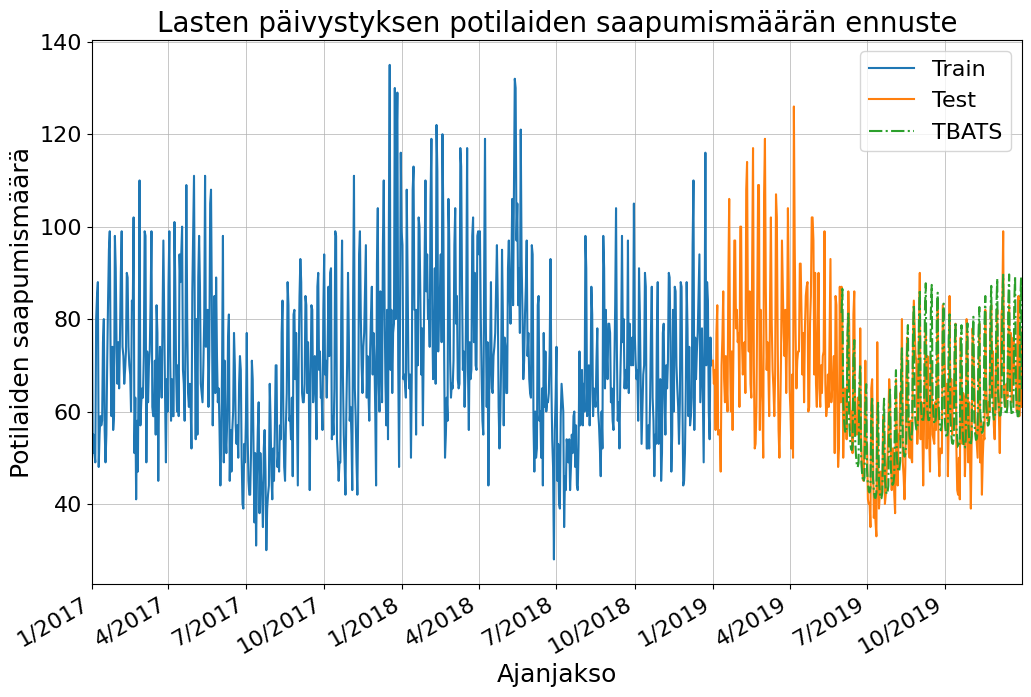

In [30]:
new_index = pd.date_range("2019-06-01", "2019-12-31")
year_pred = pd.DataFrame(np.nan, index=new_index[:-1], columns=df_train_day.columns)
year_pred.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
year_pred['TBATS'] = pickle.load(open('tbats_ER_2017-2019-06.pkl', 'rb')).forecast(steps=213)

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams.update({'font.size': 16})
ax.plot(df_train_day.arrivals, ls='-', label='Train')
ax.plot(year_test_day.arrivals, ls='-', label='Test')
ax.plot(year_pred.TBATS, ls='-.', label='TBATS')
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=20)
ax.set_xlabel('Ajanjakso', fontsize=18)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01'), pd.Timestamp('2019-07-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-12-31')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019', '7/2019', '10/2019', '1/2020'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.power((y_true - y_pred), 2))

## Tulokset
### Viiden kuukauden ennuste

In [32]:
y_pred = additive.ennuste_ARIMA
mape_arima = mean_absolute_percentage_error(df_test_day.arrivals, y_pred)
mae_arima = mean_absolute_error(df_test_day.arrivals, y_pred)
mse_arima = mean_squared_error(df_test_day.arrivals, y_pred)
rmse_arima = np.sqrt(mse_arima)
print('MAPE ARIMA:', mape_arima)
print('MAE ARIMA:', mae_arima)
print('MSE ARIMA:', mse_arima)
print('RMSE ARIMA:', rmse_arima)
print()

y_pred = additive.ennuste_SARIMA
mape_sarima = mean_absolute_percentage_error(df_test_day.arrivals, y_pred)
mae_sarima = mean_absolute_error(df_test_day.arrivals, y_pred)
mse_sarima = mean_squared_error(df_test_day.arrivals, y_pred)
rmse_sarima = np.sqrt(mse_sarima)
print('MAPE SARIMA:', mape_sarima)
print('MAE SARIMA:', mae_sarima)
print('MSE SARIMA:', mse_sarima)
print('RMSE SARIMA:', rmse_sarima)
print()

y_pred = additive.ennuste_TBATS
mape_tbats = mean_absolute_percentage_error(df_test_day.arrivals, y_pred)
mae_tbats = mean_absolute_error(df_test_day.arrivals, y_pred)
mse_tbats = mean_squared_error(df_test_day.arrivals, y_pred)
rmse_tbats = np.sqrt(mse_tbats)
print('MAPE TBATS:', mape_tbats)
print('MAE TBATS:', mae_tbats)
print('MSE TBATS:', mse_tbats)
print('RMSE TBATS:', rmse_tbats)

MAPE ARIMA: 13.725869679632336
MAE ARIMA: 11.005068011318881
MSE ARIMA: 195.40389183261402
RMSE ARIMA: 13.978694210569671

MAPE SARIMA: 12.74170834128948
MAE SARIMA: 10.043661847100253
MSE SARIMA: 161.93909746565004
RMSE SARIMA: 12.725529358955958

MAPE TBATS: 14.55527503988325
MAE TBATS: 11.51412989371656
MSE TBATS: 205.39452616435673
RMSE TBATS: 14.331591892192463


#### 42 päivän ennuste

In [33]:
y_pred = additive.ennuste_ARIMA[:42]
mape_arima = mean_absolute_percentage_error(df_test_day.arrivals[:42], y_pred)
mae_arima = mean_absolute_error(df_test_day.arrivals[:42], y_pred)
mse_arima = mean_squared_error(df_test_day.arrivals[:42], y_pred)
rmse_arima = np.sqrt(mse_arima)
print('MAPE ARIMA:', mape_arima)
print('MAE ARIMA:', mae_arima)
print('MSE ARIMA:', mse_arima)
print('RMSE ARIMA:', rmse_arima)
print()

y_pred = additive.ennuste_SARIMA[:42]
mape_sarima = mean_absolute_percentage_error(df_test_day.arrivals[:42], y_pred)
mae_sarima = mean_absolute_error(df_test_day.arrivals[:42], y_pred)
mse_sarima = mean_squared_error(df_test_day.arrivals[:42], y_pred)
rmse_sarima = np.sqrt(mse_sarima)
print('MAPE SARIMA:', mape_sarima)
print('MAE SARIMA:', mae_sarima)
print('MSE SARIMA:', mse_sarima)
print('RMSE SARIMA:', rmse_sarima)
print()

y_pred = additive.ennuste_TBATS[:42]
mape_tbats = mean_absolute_percentage_error(df_test_day.arrivals[:42], y_pred)
mae_tbats = mean_absolute_error(df_test_day.arrivals[:42], y_pred)
mse_tbats = mean_squared_error(df_test_day.arrivals[:42], y_pred)
rmse_tbats = np.sqrt(mse_tbats)
print('MAPE TBATS:', mape_tbats)
print('MAE TBATS:', mae_tbats)
print('MSE TBATS:', mse_tbats)
print('RMSE TBATS:', rmse_tbats)

MAPE ARIMA: 12.393448601282401
MAE ARIMA: 9.837615780686438
MSE ARIMA: 152.57086944336393
RMSE ARIMA: 12.351958121826836

MAPE SARIMA: 12.515341758701917
MAE SARIMA: 9.678144072994844
MSE SARIMA: 132.1951107067168
RMSE SARIMA: 11.497613261312837

MAPE TBATS: 12.088747922353066
MAE TBATS: 9.400671701511532
MSE TBATS: 125.32556198718092
RMSE TBATS: 11.19488999442071


#### 30 päivän ennuste

In [34]:
y_pred = additive.ennuste_ARIMA[:30]
mape_arima = mean_absolute_percentage_error(df_test_day.arrivals[:30], y_pred)
mae_arima = mean_absolute_error(df_test_day.arrivals[:30], y_pred)
mse_arima = mean_squared_error(df_test_day.arrivals[:30], y_pred)
rmse_arima = np.sqrt(mse_arima)
print('MAPE ARIMA:', mape_arima)
print('MAE ARIMA:', mae_arima)
print('MSE ARIMA:', mse_arima)
print('RMSE ARIMA:', rmse_arima)
print()

y_pred = additive.ennuste_SARIMA[:30]
mape_sarima = mean_absolute_percentage_error(df_test_day.arrivals[:30], y_pred)
mae_sarima = mean_absolute_error(df_test_day.arrivals[:30], y_pred)
mse_sarima = mean_squared_error(df_test_day.arrivals[:30], y_pred)
rmse_sarima = np.sqrt(mse_sarima)
print('MAPE SARIMA:', mape_sarima)
print('MAE SARIMA:', mae_sarima)
print('MSE SARIMA:', mse_sarima)
print('RMSE SARIMA:', rmse_sarima)
print()

y_pred = additive.ennuste_TBATS[:30]
mape_tbats = mean_absolute_percentage_error(df_test_day.arrivals[:30], y_pred)
mae_tbats = mean_absolute_error(df_test_day.arrivals[:30], y_pred)
mse_tbats = mean_squared_error(df_test_day.arrivals[:30], y_pred)
rmse_tbats = np.sqrt(mse_tbats)
print('MAPE TBATS:', mape_tbats)
print('MAE TBATS:', mae_tbats)
print('MSE TBATS:', mse_tbats)
print('RMSE TBATS:', rmse_tbats)

MAPE ARIMA: 10.983223139407292
MAE ARIMA: 8.050530918408855
MSE ARIMA: 97.41049792013489
RMSE ARIMA: 9.869675674516103

MAPE SARIMA: 11.546416931994049
MAE SARIMA: 8.294303710881561
MSE SARIMA: 92.60868435753154
RMSE SARIMA: 9.623340602801687

MAPE TBATS: 11.157849883932164
MAE TBATS: 8.09242060942013
MSE TBATS: 89.6767823323671
RMSE TBATS: 9.469782591610384
